In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate 
import pandas as pd
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (10,10)

We will use the PhotoZDC1 package, specifically photErrorModel, to create the errors, you can grab this package from GitHub with:<br>
git clone https://github.com/LSSTDESC/PhotoZDC1.git <br>
then add the location to your path, as below.  This implements the error model as defined in Ivezic et al (2008) (see: https://arxiv.org/abs/0805.2366 for details)
We have already added a copy to the Photo-z group workspace at NERSC at:
`/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC1/PhotoZDC1/`

In [3]:
#Add the PhotoZDC1 package to the path and import photErrorModel that will be used to generate errors 
#sys.path.insert(0, '/global/u2/s/schmidt9/PhotoZDC1/src')
sys.path.insert(0, '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC1/PhotoZDC1/src/')
import photErrorModel as errMod

Set up the LSST Error Model parameters.  Alex used some defaults from the Science Book that are not quite the same as the newest numbers from the Science Drivers document (arxiv: 0805.2366v5), so update them here.  We'll use the following number of total visits in 10 years as listed in Table 1:
NVISITS: u: 56  g: 80  r: 184  i: 184  z: 160  y: 160

And check the error model parameters against those listed in Table 2:
Nearly all values will have to be updated

Note that we should use ''theta_eff'', not ''theta'' in the tables!

There is a simple parameter to try to account for extended objects versus the point sources that these models are meant to approximate.  A quick discussion with Zeljko Ivezic and Andy Connolly years ago I believe decided on an offset in m5 value of 0.1 as a very rough approximation, so we'll add that with the errmodel.extendedsource = 0.1 parameter

We can check the param settings with the .\_\_repr\_\_ method

In [4]:
errmodel = errMod.LSSTErrorModel()
errmodel.tvis = 30.0
errmodel.nYrObs=10.0
visits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':18.4, 'LSST_i':18.4,'LSST_z':16.0,'LSST_y':16.0}
errmodel.nVisYr=visits
msky = {'LSST_u':22.99, 'LSST_g':22.26, 'LSST_r':21.20, 'LSST_i':20.48,'LSST_z':19.60,
        'LSST_y':18.61}
errmodel.msky = msky
#theta = {'LSST_u':0.81, 'LSST_g':0.77, 'LSST_r':0.73, 'LSST_i':0.71,'LSST_z':0.69,'LSST_y':0.68}
theta = {'LSST_u':0.92, 'LSST_g':0.87, 'LSST_r':0.83, 'LSST_i':0.80,'LSST_z':0.78,'LSST_y':0.76}
errmodel.theta = theta
gamma = {'LSST_u':0.038, 'LSST_g':0.039, 'LSST_r':0.039, 'LSST_i':0.039,'LSST_z':0.039,
         'LSST_y':0.039}
errmodel.gamma = gamma
#cm = {'LSST_u':23.09, 'LSST_g':24.42, 'LSST_r':24.44, 'LSST_i':24.32,'LSST_z':24.16,'LSST_y':23.73}
cmshift = {'LSST_u':22.47, 'LSST_g':24.24, 'LSST_r':24.34, 'LSST_i':24.25,'LSST_z':24.11,
           'LSST_y':23.69}
errmodel.Cm = cmshift
km = {'LSST_u':0.491, 'LSST_g':0.213, 'LSST_r':0.126, 'LSST_i':0.096,'LSST_z':0.069,'LSST_y':0.170}
errmodel.km = km
errmodel.airMass = 1.2
errmodel.extendedSource=0.1
errmodel.sigmaSys = 0.005
errmodel.__repr__

<bound method LSSTErrorModel.__repr__ of 
 LSSTErrorModel parameters:
 Exposure time = 30.0 s
 Number of years of observations = 10.0
 Number of visits per year per band: {'LSST_u': 5.6, 'LSST_g': 8.0, 'LSST_r': 18.4, 'LSST_i': 18.4, 'LSST_z': 16.0, 'LSST_y': 16.0}
 Systematic error = 0.005 mag
 Airmass = 1.2
 Sky brightness per band: {'LSST_u': 22.99, 'LSST_g': 22.26, 'LSST_r': 21.2, 'LSST_i': 20.48, 'LSST_z': 19.6, 'LSST_y': 18.61} (mag)
 Seeing per band: {'LSST_u': 0.92, 'LSST_g': 0.87, 'LSST_r': 0.83, 'LSST_i': 0.8, 'LSST_z': 0.78, 'LSST_y': 0.76} (arcsec)
 gamma per band: {'LSST_u': 0.038, 'LSST_g': 0.039, 'LSST_r': 0.039, 'LSST_i': 0.039, 'LSST_z': 0.039, 'LSST_y': 0.039}
 Cm per band: {'LSST_u': 22.47, 'LSST_g': 24.24, 'LSST_r': 24.34, 'LSST_i': 24.25, 'LSST_z': 24.11, 'LSST_y': 23.69}
 Extinction coeff. per band: {'LSST_u': 0.491, 'LSST_g': 0.213, 'LSST_r': 0.126, 'LSST_i': 0.096, 'LSST_z': 0.069, 'LSST_y': 0.17}
 Extended source model: add 0.1 mag to 5-sigma depth for point so

Let's check the 5 sigma point source depths, which should equal the following numbers at Zenith (we need to account for the $\Delta Cm$ values which account for instrumental noise, listed below are m5 values minus the $\Delta Cm^{ \infty}$ values in Table 2 of the Ivezic paper)<br>
u: 23.78 - 0.62 = 23.16<br>
g: 24.81 - 0.18 = 24.63<br>
r: 24.35 - 0.10 = 24.25<br>
i: 23.92 - 0.07 = 23.85<br>
z: 23.34 - 0.05 = 23.29<br>
y: 22.45 - 0.04 = 22.41<br>

In [5]:
filts = ('LSST_u','LSST_g','LSST_r','LSST_i','LSST_z','LSST_y')
for filt in filts:
    print ("%s  %.2f"%(filt,errmodel._m5PointSources(cmshift[filt],msky[filt],theta[filt],30.,
                                                     km[filt],1.0)))
    #args are Cm, msky, theta, tvis (30 seconds), km, and X (airmass, set to zenith so 1.0)

LSST_u  23.17
LSST_g  24.63
LSST_r  24.26
LSST_i  23.85
LSST_z  23.29
LSST_y  22.41


m5 values check out to the .01 level, so that is good!<br>
Now let's import the catalog that we want, in this instance proto-dc2_v5.0

In [6]:
import GCRCatalogs
## check version
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

GCRCatalogs = 0.8.1 | GCR = 0.8.3


In [7]:
#use this to print all available catalogs, note the "False" to actually list them all
#print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(False))))

In [8]:
gc = GCRCatalogs.load_catalog('proto-dc2_v5.0_test')

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


In [9]:
#List all available quantities in the catalog
#print('\n'.join(sorted(gc.list_all_native_quantities())[:]))

Set up some names that we will use to grab the six LSST magnitudes from the catalog reader

In [10]:
filts = ('u','g','r','i','z','y')
mag_cols = []
for filt in filts:
    mag_cols.append('LSST_filters/magnitude:LSST_%s:observed:dustAtlas'%filt)
all_cols = mag_cols
all_cols.append('redshift')
print (filts,mag_cols)

('u', 'g', 'r', 'i', 'z', 'y') ['LSST_filters/magnitude:LSST_u:observed:dustAtlas', 'LSST_filters/magnitude:LSST_g:observed:dustAtlas', 'LSST_filters/magnitude:LSST_r:observed:dustAtlas', 'LSST_filters/magnitude:LSST_i:observed:dustAtlas', 'LSST_filters/magnitude:LSST_z:observed:dustAtlas', 'LSST_filters/magnitude:LSST_y:observed:dustAtlas', 'redshift']


We will be computing the model errors for our mock galaxies.  The error fuction produced by the PZDC1.getMagError function is very smooth.  Rather than computing this for every galaxy, we will compute a grid for each filter and interpolate between them to speed up the computation.  We will set an ad hoc upper limit of 35 for magnitude, above this magnitude we will set the spline to return 99.0.  This should only really occur for flux <= 0.0 and a NaN in the log(flux).

In [11]:
mag_min = 10.
mag_max = 45.
num_gridpts = 4001 #parameters for magerr_spline
mag_grid = np.linspace(mag_min,mag_max,num_gridpts)
#print (mag_grid)

Now, define the functions for making the spline and creating new magnitudes.  For scatterMag, we need to convert to flux, add Gaussian uncertainty, then convert back to flux.

In [12]:
def makeSpline(grid,filt):
    fx =  [errmodel.getMagError(x,filt) for x in grid]
    return fx

In [13]:
def scatterMag(mag,mag_err):
    """Add proper uncertainty to magnitude
    Parmeters
    ---------
    mag: 'float' array-like
        true magnitudes 
    magerr: 'float' array-like
        magnitude uncertainties 
    Returns
    -------
    new_mag: 'float' array-like
        magnitudes with proper uncertainty, or 99 if flux was negative after error added
    """
    floor = 1.e-14 # set a minimum flux value, corresponding to mag = 35 for now
    floor_mag = -2.5*np.log10(floor)
    flux = np.power(10.,-0.4*mag) 
    err_flux = np.multiply(flux,mag_err)*0.4*np.log(10.)
    mask = (err_flux<0.0) #check for objects that have scattered to negative flux
    err_flux[mask] = 0.005
    tmperr = np.random.normal(0.0,err_flux)
    new_flux = np.subtract(flux,tmperr)
    mask = (new_flux < floor)
    new_flux[mask] = floor
    new_mag = -2.5*np.log10(new_flux)
    mask2 = np.logical_or(new_mag != new_mag,new_mag>=floor_mag)#error for NaN or Inf, which can happen if flux is negative or 0
    new_mag[mask2] = 99.0
    print ("Number of non-detections: %d"%(np.sum(mask2)))
    return new_mag

Now, read in the data, create a Pandas dataframe for the true magnitudes

In [14]:
%%time
#include filters for when we are testing subsets so things run faster
#data = gc.get_quantities(all_cols,filters = ['mag_i < 25.5'])
data = gc.get_quantities(all_cols)
df = pd.DataFrame(data, columns = all_cols)

CPU times: user 106 ms, sys: 520 ms, total: 626 ms
Wall time: 625 ms


In [15]:
print ("number of objects in catalog: %d"%(len(data['redshift'])))

number of objects in catalog: 18286706


Next, for each filter, compute magnitude errors, add the uncertainties to the magnitudes, and re-calculate the magnitude errors.  Then add these new "scattered" (in flux) quantities to the data frame

In [16]:
%%time
for filt,magcol in zip(filts,mag_cols):
    print ("working on filter %s"%(filt))
    tmpmag = data[magcol]
    grid_errs = makeSpline(mag_grid,'LSST_%s'%filt)
    #print (grid_errs)
    errspline = scipy.interpolate.interp1d(mag_grid,grid_errs,kind='linear',bounds_error=False,
                                           fill_value=99.0)#return 99.0 outside interval
    newerrx = errspline(tmpmag)
    newmag = np.array(scatterMag(tmpmag,newerrx),dtype=np.float32)
    #we need to recalculate the magnitude error based on the new magnitude    
    newerr = np.array(errspline(newmag),dtype=np.float32)  
    magname = 'scatmag_%s'%filt
    errname = 'scaterr_%s'%filt
    df[magname] = newmag
    df[errname] = newerr

working on filter u
Number of non-detections: 4204266
working on filter g
Number of non-detections: 1103119
working on filter r
Number of non-detections: 317856
working on filter i
Number of non-detections: 154517
working on filter z
Number of non-detections: 292603
working on filter y
Number of non-detections: 989234
CPU times: user 31.3 s, sys: 3.55 s, total: 34.8 s
Wall time: 34.8 s


Take a look at the dataframe columns and other information

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18286706 entries, 0 to 18286705
Data columns (total 19 columns):
LSST_filters/magnitude:LSST_u:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_g:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_r:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_i:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_z:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_y:observed:dustAtlas    float32
redshift                                            float64
scatmag_u                                           float32
scaterr_u                                           float32
scatmag_g                                           float32
scaterr_g                                           float32
scatmag_r                                           float32
scaterr_r                                           float32
scatmag_i                                           float32
scaterr_i                                    

In [18]:
df.tail()

,LSST_filters/magnitude:LSST_u:observed:dustAtlas,LSST_filters/magnitude:LSST_g:observed:dustAtlas,LSST_filters/magnitude:LSST_r:observed:dustAtlas,LSST_filters/magnitude:LSST_i:observed:dustAtlas,LSST_filters/magnitude:LSST_z:observed:dustAtlas,LSST_filters/magnitude:LSST_y:observed:dustAtlas,redshift,scatmag_u,scaterr_u,scatmag_g,scaterr_g,scatmag_r,scaterr_r,scatmag_i,scaterr_i,scatmag_z,scaterr_z,scatmag_y,scaterr_y
18286701,28.414019,28.345297,28.071260,27.465656,27.148478,27.183205,0.966589,29.251366,2.441921,28.200148,0.558436,28.236435,0.536846,28.032598,0.619356,27.194574,0.531089,99.000000,99.000000
18286702,26.704805,26.944096,27.183264,27.209818,27.301701,27.430613,0.970879,26.897272,0.736444,27.147570,0.246873,27.350008,0.270441,27.012098,0.285355,27.054735,0.479127,99.000000,99.000000
18286703,26.782017,27.037832,27.268320,27.282356,27.356901,27.460501,0.974865,26.405991,0.522143,26.968353,0.212795,26.918926,0.189105,27.001541,0.282926,99.000000,99.000000,27.483822,1.155366
18286704,33.038513,31.825632,30.492952,29.524033,28.875637,28.599476,0.966602,32.260963,5.338370,99.000000,99.000000,29.371359,1.125151,33.036404,4.732379,29.432449,1.937092,99.000000,99.000000
18286705,29.003000,28.806541,28.338758,27.600582,27.121696,27.046762,0.975634,28.023470,1.431298,28.321348,0.608785,28.208164,0.525908,28.111855,0.654513,26.885639,0.421797,27.327980,1.055871


For some reason pd.rename does not seem to be working correctly, so temporarily creat some shorter names for the "true" magnitdues from GCR before errors are added

In [19]:
utrue = df['LSST_filters/magnitude:LSST_u:observed:dustAtlas']
gtrue = df['LSST_filters/magnitude:LSST_g:observed:dustAtlas']
rtrue = df['LSST_filters/magnitude:LSST_r:observed:dustAtlas']
itrue = df['LSST_filters/magnitude:LSST_i:observed:dustAtlas']
ztrue = df['LSST_filters/magnitude:LSST_z:observed:dustAtlas']
ytrue = df['LSST_filters/magnitude:LSST_y:observed:dustAtlas']

Now, plot some figures to see how things look, compare color-color plot of "true" magnitudes versus after scattering with error.  Only plot every 100th point to save some time and lower the point density

(-1.05, 2.05)

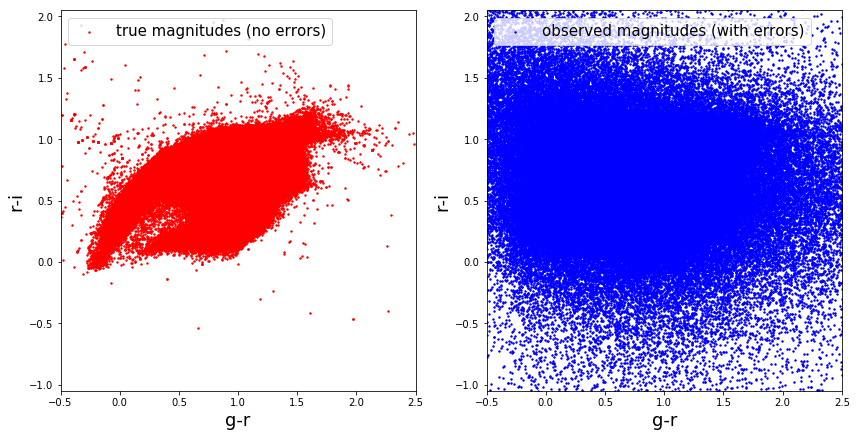

In [28]:
fig = plt.figure(figsize=(14,7))
ax = plt.subplot(122)
plt.scatter(df['scatmag_g'][::100]-df['scatmag_r'][::100],
            df['scatmag_r'][::100]-df['scatmag_i'][::100],
            marker='o',c='b',s=2,label='observed magnitudes (with errors)')
plt.xlabel("g-r",fontsize=18)
plt.ylabel("r-i",fontsize=18)
plt.legend(loc='upper left',fontsize=15)
plt.xlim([-.5,2.5])
plt.ylim([-1.05,2.05])

bx = plt.subplot(121)
plt.scatter(gtrue[::100]-rtrue[::100],rtrue[::100]-itrue[::100],marker='o',s=2,c='r',label='true magnitudes (no errors)')
plt.xlabel("g-r",fontsize=18)
plt.ylabel("r-i",fontsize=18)
plt.legend(loc='upper left',fontsize=15)
plt.xlim([-.5,2.5])
plt.ylim([-1.05,2.05])

Let's compare the errors as a function of magnitude for the "true" errors versus the "scattered" errors, the magnitudes with errors will form a nice perfect line, while the true magnitudes show the scatter from the re-computation of the errors.  

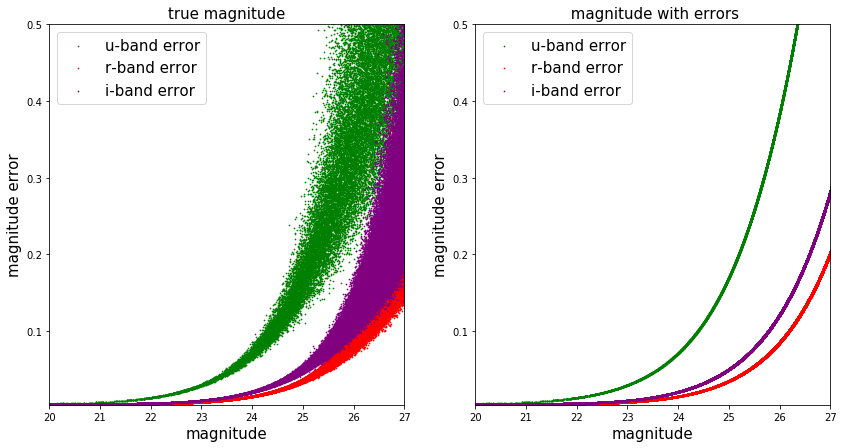

In [21]:
fig = plt.figure(figsize=(14,7))
ax = plt.subplot(122)
plt.scatter(df['scatmag_u'][::100],df['scaterr_u'][::100],s=2,marker='.',c='g',label="u-band error")
plt.scatter(df['scatmag_r'][::100],df['scaterr_r'][::100],s=2,marker='.',c='r',label ="r-band error")
plt.scatter(df['scatmag_i'][::100],df['scaterr_i'][::100],s=2,marker='.',c='purple',label = "i-band error")
plt.xlim([20,27])
plt.ylim([.004,.5])
plt.legend(loc='upper left',fontsize=15)
plt.xlabel('magnitude',fontsize=15)
plt.ylabel('magnitude error',fontsize=15)
plt.title(" magnitude with errors",fontsize=15)

bx = plt.subplot(121)
plt.scatter(utrue[::100],df['scaterr_u'][::100],s=2,marker='.',c='g',label="u-band error")
plt.scatter(rtrue[::100],df['scaterr_r'][::100],s=2,marker='.',c='r',label ="r-band error")
plt.scatter(itrue[::100],df['scaterr_i'][::100],s=2,marker='.',c='purple',label = "i-band error")
plt.xlim([20,27])
plt.ylim([.004,.5])
plt.legend(loc='upper left',fontsize=15)
plt.xlabel('magnitude',fontsize=15)
plt.ylabel('magnitude error',fontsize=15)
plt.title("true magnitude",fontsize=15)

Make a couple color vs redshift and  color vs color plots of the "truth" data before uncertainties have been added to the magnitudes, compare them to after errors added.  We will restrict ourselves to the i<25.3 "gold sample" to avoid the large errors associated with the very faint objects, where colors can be scattered from the usual locus by quite a bit.

let's also look at the number of non-detections in the "gold sample" with i<25.3, which should be less scary than the above numbers for the full sample<br> Almost all of the non-detections are in u-band

In [22]:
sfilts = ('scatmag_u','scatmag_g','scatmag_r','scatmag_i','scatmag_z','scatmag_y')
gold_df = df[df['scatmag_i']<25.3]
for sfilt in sfilts:
 print ("number of non-detects in band %s: %d"%(sfilt,len(gold_df[gold_df[sfilt]>90.])))

number of non-detects in band scatmag_u: 255336
number of non-detects in band scatmag_g: 171
number of non-detects in band scatmag_r: 0
number of non-detects in band scatmag_i: 0
number of non-detects in band scatmag_z: 0
number of non-detects in band scatmag_y: 2


In [23]:
ug_t = utrue - gtrue
gr_t = gtrue - rtrue
ri_t = rtrue - itrue
gold_mask = (itrue<25.3)
ug_tgold = ug_t[gold_mask]
gr_tgold = gr_t[gold_mask]
ri_tgold = ri_t[gold_mask]
sz_gold = df['redshift'][gold_mask]

In [24]:
ug_sgold = df['scatmag_u'][gold_mask]-df['scatmag_g'][gold_mask]
gr_sgold = df['scatmag_g'][gold_mask]-df['scatmag_r'][gold_mask]
ri_sgold = df['scatmag_r'][gold_mask]-df['scatmag_i'][gold_mask]

Plot g-r color vs. redshift with the new uncertainties to make sure the colors look reasonable

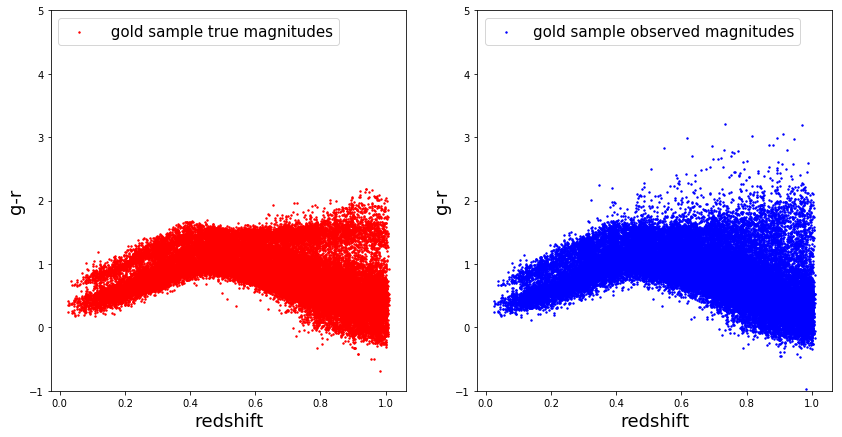

In [25]:
fig = plt.figure(figsize=(14,7))
ax = plt.subplot(121)
plt.scatter(sz_gold[::100],gr_tgold[::100],marker='o',s=2,c='r',label=" gold sample true magnitudes")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("g-r",fontsize=18)
plt.ylim([-1,5])
plt.legend(loc='upper left',fontsize=15)

bx = plt.subplot(122)
plt.scatter(sz_gold[::100],gr_sgold[::100],marker='o',s=2,c='b',label="gold sample observed magnitudes")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("g-r",fontsize=18)
plt.ylim([-1,5])
plt.legend(loc='upper left',fontsize=15)

(-1.0, 2.7)

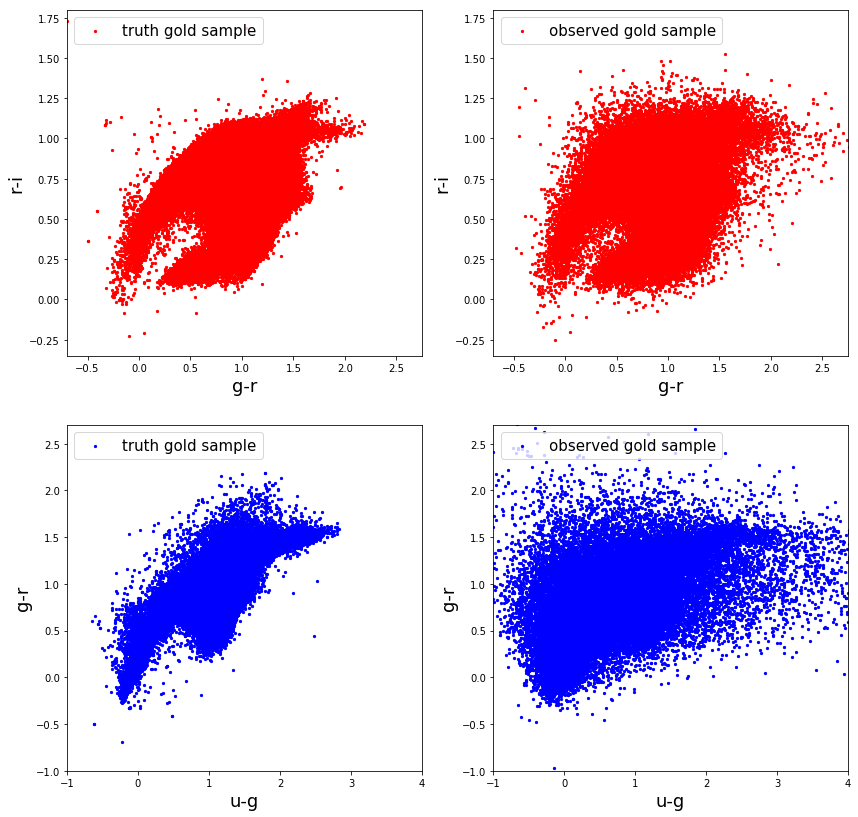

In [26]:
fig = plt.figure(figsize=(14,14))
ax=plt.subplot(221)
ax.scatter(gr_tgold[::100],ri_tgold[::100],marker='.',s=20,c='r',label="truth gold sample")
plt.xlabel('g-r',fontsize=18)
plt.ylabel('r-i',fontsize=18)
plt.legend(loc='upper left',fontsize=15)
plt.xlim([-.7,2.75])
plt.ylim([-.35,1.8])

bx = plt.subplot(223)
bx.scatter(ug_tgold[::100],gr_tgold[::100],marker='.',s=20,c='b',label="truth gold sample")
plt.xlabel('u-g',fontsize=18)
plt.ylabel('g-r',fontsize=18)
plt.legend(loc='upper left',fontsize=15)
plt.xlim([-1.,4])
plt.ylim([-1.,2.7])

cx=plt.subplot(222)
cx.scatter(gr_sgold[::100],ri_sgold[::100],marker='.',s=20,c='r',label="observed gold sample")
plt.xlabel('g-r',fontsize=18)
plt.ylabel('r-i',fontsize=18)
plt.legend(loc='upper left',fontsize=15)
plt.xlim([-.7,2.75])
plt.ylim([-.35,1.8])

dx = plt.subplot(224)
dx.scatter(ug_sgold[::100],gr_sgold[::100],marker='.',s=20,c='b',label="observed gold sample")
plt.xlabel('u-g',fontsize=18)
plt.ylabel('g-r',fontsize=18)
plt.legend(loc='upper left',fontsize=15)
plt.xlim([-1.,4])
plt.ylim([-1.,2.7])

we see just how much scatter has been added, particularly in u-g.  We have restricted the plot area to exclude non-detections: there is a second cloud of points with u-g and g-r~70-75 due to very faint objects that were not detected in bands, (these can be seen by changing the x-limit on the u-g plots).

Now write the pandas dataframe out to an hdf5 file

In [27]:
outfile_protodc2 = "protodc2_v5_ugrizy_witherrs_test.h5" #put name with "test" to not overwrite big file
#outfile_protodc2 = "protodc2_v5_ugrizy_witherrs.h5" 
df.to_hdf(outfile_protodc2, 'df')